In [1]:
# DDoS attacks classifier:

import pandas as pd
import numpy as np

# Suppress specific warnings thats not important:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

from tabulate import tabulate
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# models used in the code:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

#  Train datasets:
data1_portmap = pd.read_csv("https://ddosciu.s3.us-east-2.amazonaws.com/Portmap.csv", low_memory=False)
data1_ldap = pd.read_csv("https://ddosciu.s3.us-east-2.amazonaws.com/LDAP.csv" ,low_memory=False)
data2 = pd.read_csv("https://ddosciu.s3.us-east-2.amazonaws.com/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)
# Test datasets:
data3 = pd.read_csv("https://ddosciu.s3.us-east-2.amazonaws.com/UNSW-NB15.csv", low_memory=False)
# Concatenate data1_portmap and data1_ldap:
data1 = pd.concat([data1_portmap, data1_ldap], ignore_index=True)

In [2]:
data1.head(5)

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,24,192.168.50.254-224.0.0.5-0-0-0,192.168.50.254,0,224.0.0.5,0,0,2018-11-03 09:18:16.964447,114456999,45,...,28337.112288,98168.0,3.0,9529897.25,351582.631269,10001143.0,9048097.0,0,0,BENIGN
1,26,192.168.50.253-224.0.0.5-0-0-0,192.168.50.253,0,224.0.0.5,0,0,2018-11-03 09:18:18.506537,114347504,56,...,121314.911865,420255.0,4.0,9493929.75,351541.079539,9978130.0,8820294.0,0,0,BENIGN
2,176563,172.217.10.98-192.168.50.6-443-54799-6,192.168.50.6,54799,172.217.10.98,443,6,2018-11-03 09:18:18.610576,36435473,6,...,0.000000,62416.0,62416.0,36373056.00,0.000000,36373056.0,36373056.0,0,0,BENIGN
3,50762,172.217.7.2-192.168.50.6-443-54800-6,192.168.50.6,54800,172.217.7.2,443,6,2018-11-03 09:18:18.610579,36434705,6,...,0.000000,62413.0,62413.0,36372291.00,0.000000,36372291.0,36372291.0,0,0,BENIGN
4,87149,172.217.10.98-192.168.50.6-443-54801-6,192.168.50.6,54801,172.217.10.98,443,6,2018-11-03 09:18:18.610581,36434626,6,...,0.000000,62409.0,62409.0,36372216.00,0.000000,36372216.0,36372216.0,0,0,BENIGN


In [3]:
data1.columns

Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [4]:
data1[' Label'].value_counts()

 Label
LDAP       1905191
NetBIOS     202919
Portmap     186960
BENIGN        9858
Name: count, dtype: int64

In [5]:
data2.head(5)

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
data2.columns

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [7]:
data2[' Label'].value_counts()

 Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64

In [8]:
data3.head(5)

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,214392,9,21,388,24564,194,0,43.111111,85.545959,1460,...,20,0.0,0.0,0,0,0.0,0.0,0,0,4
1,2376792,9,3,752,0,188,0,83.555556,99.084700,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,7
2,131350,10,3,7564,0,1460,0,756.400000,690.497277,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,4
3,164796,6,3,770,0,385,0,128.333333,198.813145,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,3
4,163418,6,3,400,0,200,0,66.666667,103.279556,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,6


In [9]:
data3.columns

Index(['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag C

In [10]:
data3['Label'].value_counts()

Label
0    358332
4     30951
5     29613
7     16735
6      4632
3      4467
8      2102
2       452
1       385
9       246
Name: count, dtype: int64

In [11]:
# Define the features to focus on:
features = [
    ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
    'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
    'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std',
    ' Fwd IAT Mean', ' Fwd IAT Std', 'Fwd Packets/s', ' Bwd Packets/s',
    ' SYN Flag Count', ' RST Flag Count', ' ACK Flag Count', ' PSH Flag Count',
    ' Avg Fwd Segment Size', ' Avg Bwd Segment Size', 'Init_Win_bytes_forward',
    ' Init_Win_bytes_backward', ' act_data_pkt_fwd', 'Active Mean', 'Idle Mean'
]

In [12]:
# Define the old and new column names:
old_columns = [
    'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
    'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
    'Flow Bytes/s','Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std',
    'Fwd IAT Mean', 'Fwd IAT Std','Fwd Packets/s', 'Bwd Packets/s',
    'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count', 'PSH Flag Count',
    'Avg Fwd Segment Size','Avg Bwd Segment Size', 'FWD Init Win Bytes',
    'Bwd Init Win Bytes','Fwd Act Data Pkts', 'Active Mean', 'Idle Mean','Fwd Segment Size Avg',
       'Bwd Segment Size Avg',
]

new_columns = [
    ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
    'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
    'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std',
    ' Fwd IAT Mean', ' Fwd IAT Std', 'Fwd Packets/s', ' Bwd Packets/s',
    ' SYN Flag Count', ' RST Flag Count', ' ACK Flag Count', ' PSH Flag Count',
    ' Avg Fwd Segment Size', ' Avg Bwd Segment Size', 'Init_Win_bytes_forward',
    ' Init_Win_bytes_backward', ' act_data_pkt_fwd', 'Active Mean', 'Idle Mean',' Avg Fwd Segment Size', ' Avg Bwd Segment Size'
]

# Create a dictionary for renaming columns:
rename_dict = dict(zip(old_columns, new_columns))

# Rename columns:
data3.rename(columns=rename_dict, inplace=True)

In [13]:
# Select only the extracted features from each dataset:
data1 = data1[features + [' Label']]
data2 = data2[features + [' Label']]
data3 = data3[features + ['Label']]

In [14]:
# Custom labeling function:
def custom_labeling(dataset, dataset_name):
    if dataset_name == 'CIC-DDoS2019':
        dataset[' Label'] = dataset[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    elif dataset_name == 'CIC-IDS2017':
        dataset[' Label'] = dataset[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    elif dataset_name == 'UNSW-NB15':
        dataset['Label'] = dataset['Label'].apply(lambda x: 3 if x == 3 else 0)
    return dataset

In [15]:
# Apply custom labeling:
data1 = custom_labeling(data1, 'CIC-DDoS2019')
data2 = custom_labeling(data2, 'CIC-IDS2017')
data3 = custom_labeling(data3, 'UNSW-NB15')

In [16]:
def preprocess_data(data):
    # Separate features and target:
    X = data.drop([' Label', 'Label'], axis=1, errors='ignore')
    y = data[' Label'] if ' Label' in data.columns else data['Label']

    # Replace infinite values with NaN:
    X = X.replace([np.inf, -np.inf], np.nan)

    # Handle missing and NaN values:
    X = X.fillna(X.mean())

    # Scale features:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

In [17]:
X, y = preprocess_data(data3)

In [18]:
# Initial split (90% train, 10% temp)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Split the temp set into train and validation (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

Logistic Regression:
Cross-Validation Accuracy: 0.990089861281426
Test Accuracy: 0.9900875156277906
F1 score: 0.9853935919029888
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     44345
           3       0.64      0.02      0.03       447

    accuracy                           0.99     44792
   macro avg       0.81      0.51      0.51     44792
weighted avg       0.99      0.99      0.99     44792

Confusion Matrix:
[[44341     4]
 [  440     7]]


Random Forest:
Cross-Validation Accuracy: 0.9912712637453305
Test Accuracy: 0.9913377388819432
F1 score: 0.9891209004806136
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     44345
           3       0.71      0.23      0.34       447

    accuracy                           0.99     44792
   macro avg       0.85      0.61      0.67     44792
weighted avg       0.99      0.99      0.99     44792

Confusion Matrix:
[[44303    42]
 [  346  

<Figure size 1000x600 with 0 Axes>

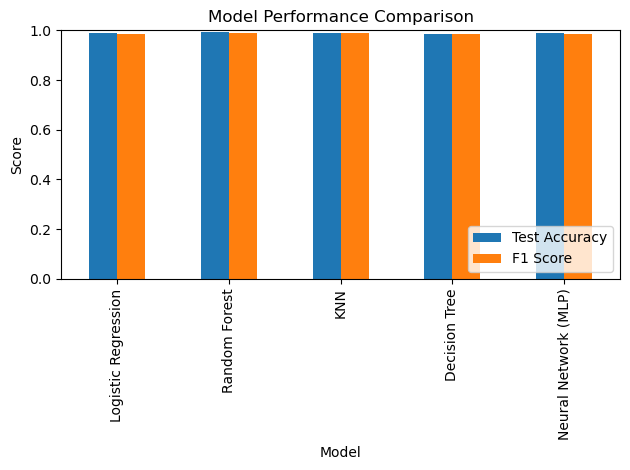

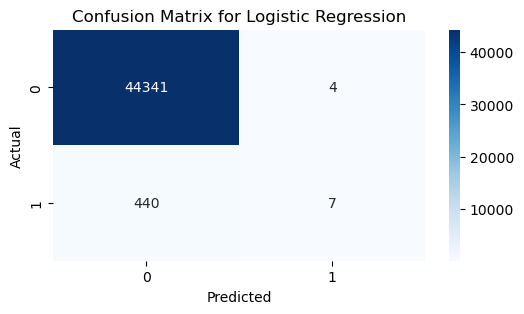

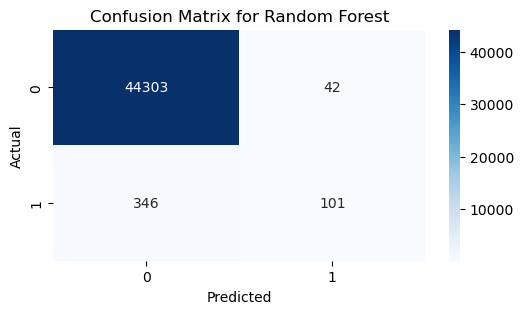

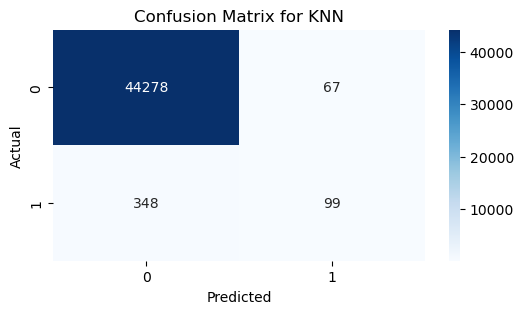

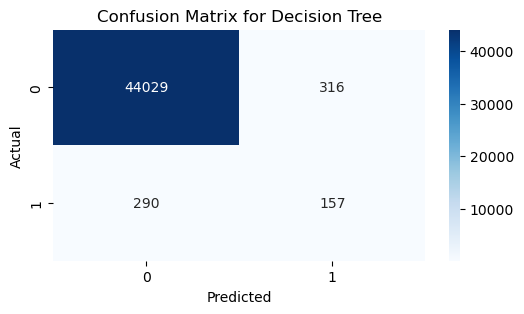

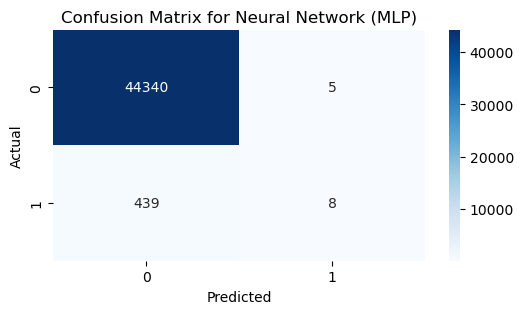


Model Performance Table:
+----+----------------------+-----------------------------+-----------------+
|    | Model                |   Cross-Validation Accuracy |   Test Accuracy |
+====+======================+=============================+=================+
|  0 | Logistic Regression  |                    0.99009  |        0.990088 |
+----+----------------------+-----------------------------+-----------------+
|  1 | Random Forest        |                    0.991271 |        0.991338 |
+----+----------------------+-----------------------------+-----------------+
|  2 | KNN                  |                    0.990701 |        0.990735 |
+----+----------------------+-----------------------------+-----------------+
|  3 | Decision Tree        |                    0.987395 |        0.986471 |
+----+----------------------+-----------------------------+-----------------+
|  4 | Neural Network (MLP) |                    0.990174 |        0.990088 |
+----+----------------------+---------

In [19]:
from sklearn.model_selection import cross_val_score

# Train and evaluate models with cross-validation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(100,), 
        activation="relu",  
        solver="adam",  
        max_iter=200,  
        random_state=42,
    )
}

results = []

for name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": name,
        "Cross-Validation Accuracy": cv_scores.mean(),
        "Test Accuracy": accuracy,
        "F1 Score": f1,
        "Classification Report": class_report,
        "Confusion Matrix": conf_matrix
    })

    print(f"{name}:")
    print(f"Cross-Validation Accuracy: {cv_scores.mean()}")
    print(f"Test Accuracy: {accuracy}")
    print(f"F1 score: {f1}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n")

# Convert results to DataFrame for plotting
results_df = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(10, 6))
results_df.plot(x='Model', y=['Test Accuracy', 'F1 Score'], kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Plot confusion matrices
for result in results:
    plt.figure(figsize=(6, 3))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {result['Model']}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Create a table to show model performance
performance_table = results_df[["Model", "Cross-Validation Accuracy", "Test Accuracy"]]
print("\nModel Performance Table:")
print(tabulate(performance_table, headers='keys', tablefmt='grid'))
performance_table.to_csv('performance_tableDS3.csv', index=False)

In [20]:
# Create a DataFrame with the results
results_df = pd.DataFrame(results)